# Проект 6. Принятие решений в бизнесе. 

Предоставлены данные крупного интернет-магазина. Необходимо приоритизировать предоставленные отделом маркетинга гипотезы для увеличения выручки, запустить A/B-тест и проанализировать его результаты. 

Описание данных:

- hypothesis.csv - датасет, хранящий данные о гипотезах. Содержит краткое описание гипотезы, охват пользователей по 10-балльной шкале, влияние на пользователей по 10-балльной шкале, и затраты ресурсов на проверку гипотезы по 10-балльной шкале. 
- orders.csv - хранит данные о заказах пользователей интернет-магазина. Содержит идентификатор заказа, пользователя, совершившего заказ, дату заказа, выручку от заказа, и группу теста, в которую попал заказ. 
- visitors - хранит данные о посетителях интернет-магазина. Содержит дату посещения, группу A/B-теста и количество пользователей в указанную дату в указанной группе A/B-теста.

План действий:
- Приоритизировать гипотезы при помощи фреймворков ICE и RICE, изучить результаты и объяснить, с чем связаны изменения в приоритизации. 
- Проанализировать полученные результаты A/B-теста: построить графики, рассчитать перцентили и статистическую значимость. 

## Импорт библиотек, загрузка датасетов, предобработка данных.

В певую очередь необходимо импортировать библиотеки и открыть датасеты.

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [8]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.options.display.max_colwidth = 130
hypothesis.head()

In [9]:
orders = pd.read_csv('/datasets/orders.csv')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.head()

In [10]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors.head()

Теперь необходимо привести имена столбцов к единому регистру и проверить, нет ли в них пропусков или дубликатов. Для этого я воспользуюсь заранее написанной функцией.

In [12]:
def fix_and_check (dataset):
    dataset.columns = [x.lower().replace(' ', '_') for x in dataset.columns]
    dataset.columns
    print('Пропуски: ')
    print(dataset.isna().sum())
    print('*'*50)
    print('Дубликаты: ')
    print(dataset.duplicated().sum())
    print('*'*50)
    print('Типы данных: ')
    print(dataset.dtypes)
    return dataset

In [13]:
hypothesis = fix_and_check(hypothesis)

In [14]:
orders = fix_and_check(orders)

In [15]:
visitors = fix_and_check(visitors)

Данные не содержат пропусков и дубликатов, и названия столбцов теперь имеют удобный формат. Можно приступать к вычислениям. 

In [17]:
visitors.groupby('group').count()

Всего в предоставленных данных для А/В-тестов две группы, по 31 посетителю сайта в каждой

In [20]:
print(min(visitors['date']))
max(visitors['date'])

Период проведения эксперимента - с 01.08 по 31.08, один месяц. 

In [22]:
orders.groupby('group').count()

В тестовой группе В сделали больше заказов, чем в А. 

## Часть 1. Приоритизация гипотез. 

В предоставленных данных есть гипотезы и их показатели. Для их приоритизации мы используем методы ICE и RICE и сравним полученные результаты. 

### Метод ICE

In [26]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']), 2)

display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

По методу ICE наибольший приоритет имеет восьмая гипотеза.

### Метод RICE

In [27]:
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']), 2)

display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

По методу RICE на первом месте гипотеза номер 7, а 8 только на пятом месте.

### Промежуточный вывод

Согласно методу ICE, наибольший приоритет имеет гипотеза 8, предлагающая запустить акцию, дающую скидку на товар в день рождения пользователя. 

Согласно методу Rice, наиболее приоритетна гипотеза 7 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email рассылок. 

Такая разница в результатах, вероятно, связана с тем, что метод ICE не учитывает, скольких пользователей затронет вносимое изменение. Акция, дающая скидку на товар в день рождения пользователя, затронет только часть пользователей - тех, кто указал свою дату рождения, и не затронет единовременно всех пользователей. Форма подписки на всех основных страницах затронет большую часть пользователей интернет-магазина. 

## Часть 2. Анализ A/B-теста

Результаты проведённого A/B теста описаны в файлах orders и visitors. Нужно проанализировать эти результаты. 

Для удобства работы создаём датафрейм datesGroups с уникальными парами значений date и group из таблицы orders и создадим переменную ordersAggregated, содержащую дату, группу теста, число уникальных заказов в группе теста, число уникальных пользователей, совершивших хотя бы 1 заказ, суммарную выручку заказов в группе теста по указанную дату включительно и переменную visitorsAggregated, содержащую дату, группу теста, количество уникальных посетителей в группе теста. Последняя нужная переменная - cumulativeData, которыя объединит в себе ordersAggregated и visitorsAggregated.

In [30]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

Проверим, корректно ли был создан датафрейм cummulativaData, сравним минимальную и максимальную даты в нём с теми, что были найдены в исходном датафрейме - с 01.08 по 31.08, один месяц.

In [31]:
print(min(cumulativeData['date']))
max(cumulativeData['date'])

Всё верно, даты совпадают.

Построим график кумулятивной выручки по группам. 

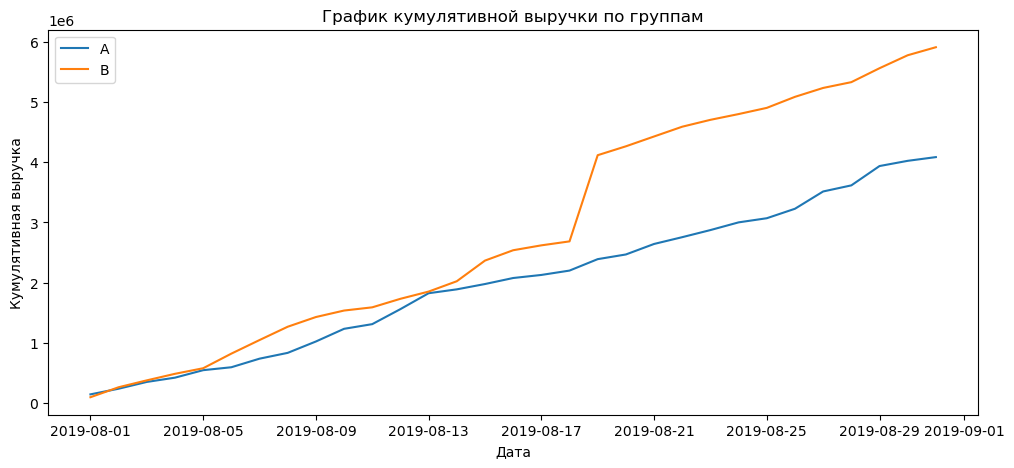

In [40]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title(label='График кумулятивной выручки по группам')
plt.legend();

На графике видно, что в середине теста сегмент B вырвался вперёд и в дальнейшем лидировал весь остаток теста. 

Возможно, на данные повлияли аномально большие покупки, но также возможно, что количество заказов стало больше - в начале вычислений мы уже установили, что в группе В сделали больше заказов.

Построим график кумулятивного среднего чека по группам.

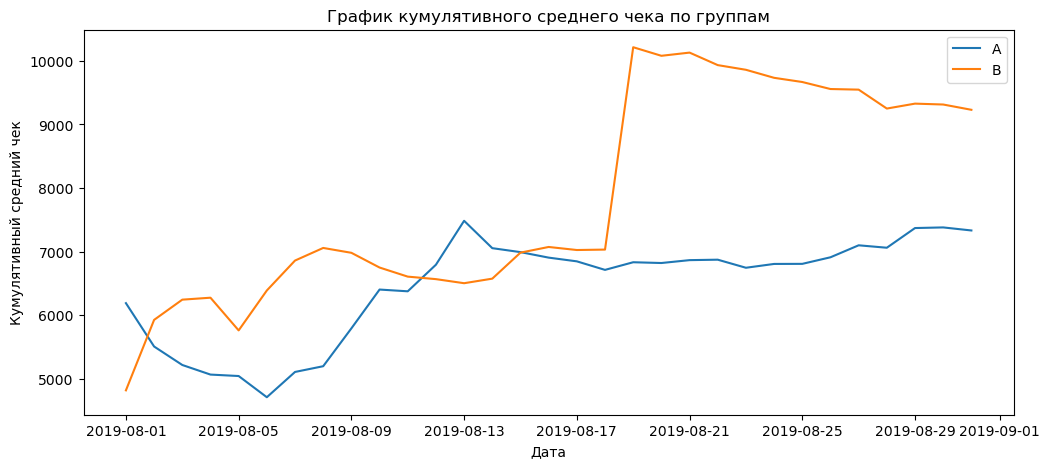

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.title(label='График кумулятивного среднего чека по группам')
plt.legend();

Кумулятивное значение среднего чека по сегментам сильно колеблется, в сегменте B произошёл значительный скачок около середины теста. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

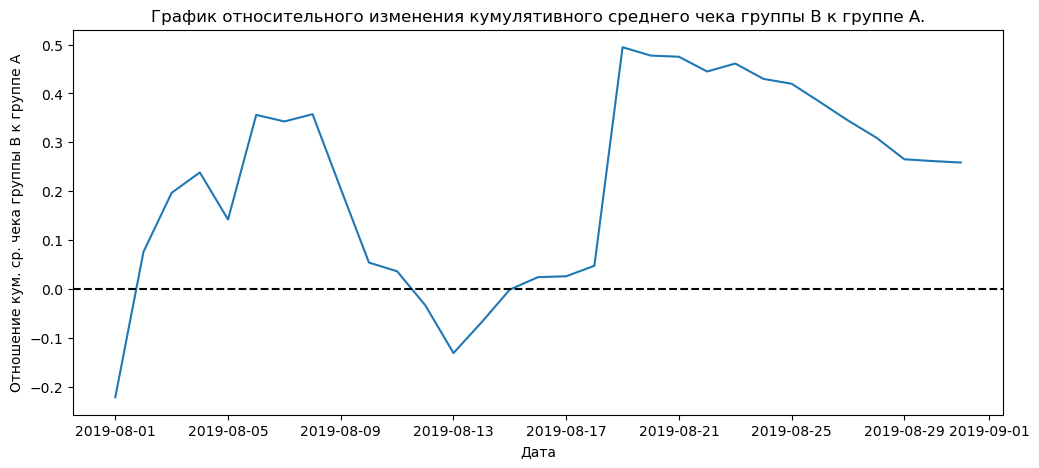

In [49]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xlabel('Дата')
plt.ylabel('Отношение кум. ср. чека группы В к группе А')
plt.title(label='График относительного изменения кумулятивного среднего чека группы B к группе A.')
plt.axhline(y=0, color='black', linestyle='--');

Результаты теста здесь значительно и резко менялись несколько раз. Видимо, тогда и были совершены аномальные заказы.  

Построим график кумулятивного среднего количества заказов на посетителя по группам.

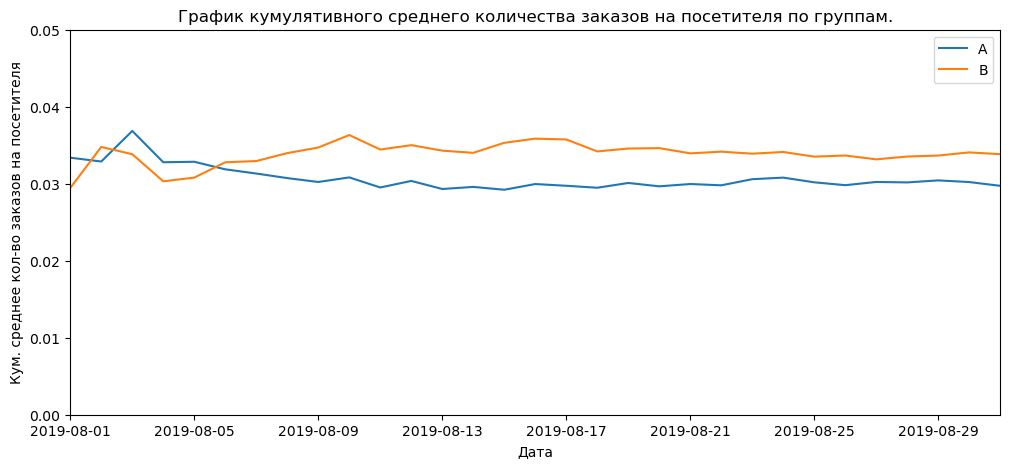

In [50]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xlabel('Дата')
plt.ylabel('Кум. среднее кол-во заказов на посетителя')
plt.title(label='График кумулятивного среднего количества заказов на посетителя по группам.')
plt.legend()

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05]);

Конверсия группы В поднялась выше конверсии группы А ещё в самом начале теста и стабильно держалась выше.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

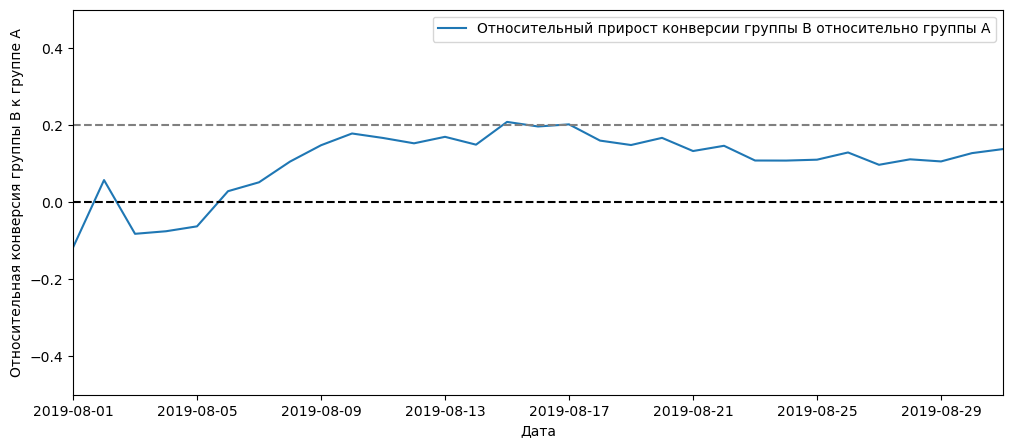

In [51]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Относительная конверсия группы В к группе А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5]);

Почти с самого начала теста группа В лидирует по конверсии, и достигала прироста в 20% относительно группы А. 

Построим точечный график количества заказов по пользователям.

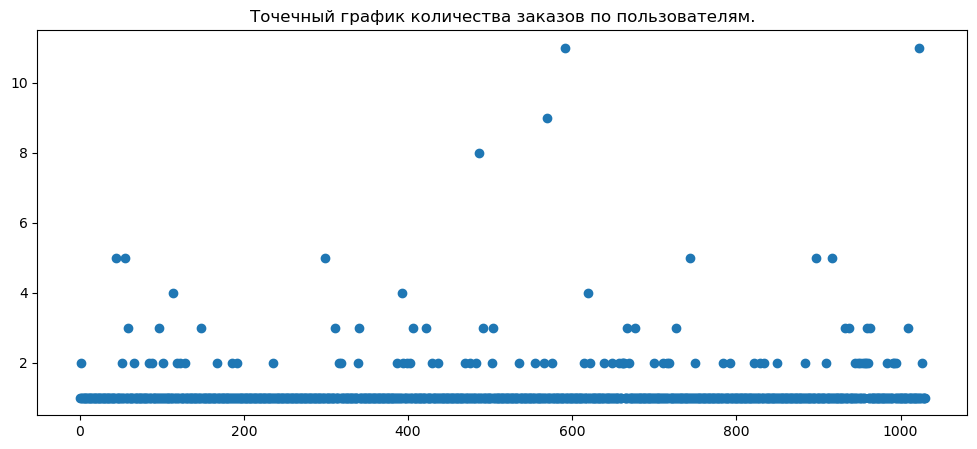

In [45]:
ordersByUsers = orders.groupby('visitorid', as_index=False).agg({'transactionid' : 'nunique'})

ordersByUsers = ordersByUsers.rename(
 columns={
'visitorid': 'userid',
'transactionid': 'orders'
 }
)

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(12, 5))
plt.title(label='Точечный график количества заказов по пользователям.')
plt.scatter(x_values, ordersByUsers['orders']);

Большинство пользователей совершили один заказ, пользователей, заказавших более двух раз, довольно мало и они вполне могут быть аномальными. Рассчитаем выборочные перцентили, чтобы понять, аномальны ли они.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [18]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

Не более 5% пользователей совершали более двух заказов. И не более 1% - более четырёх.

Построим точечный график стоимостей заказов.

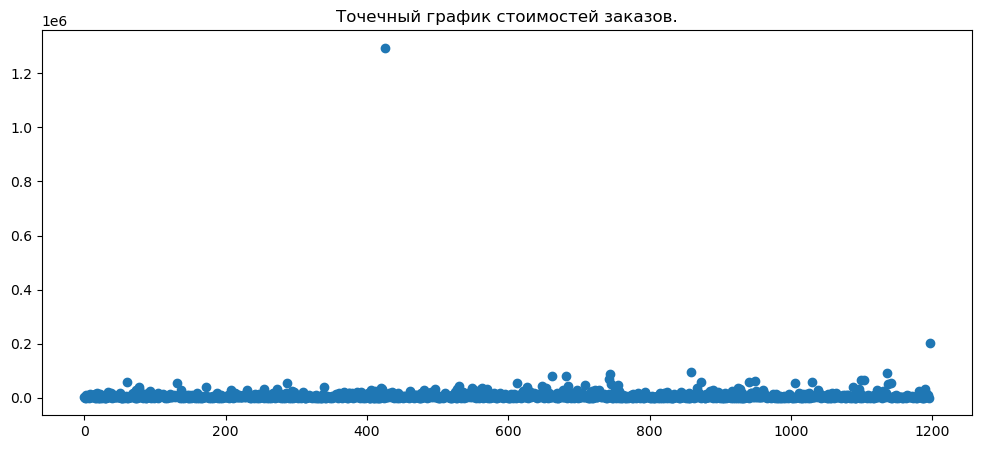

In [46]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12, 5))
plt.title(label='Точечный график стоимостей заказов.')
plt.scatter(x_values, orders['revenue']);

Заказов дороже 200 000 рублей очень мало. Один заказ на 1,2 миллиона выглядит весьма аномально. 

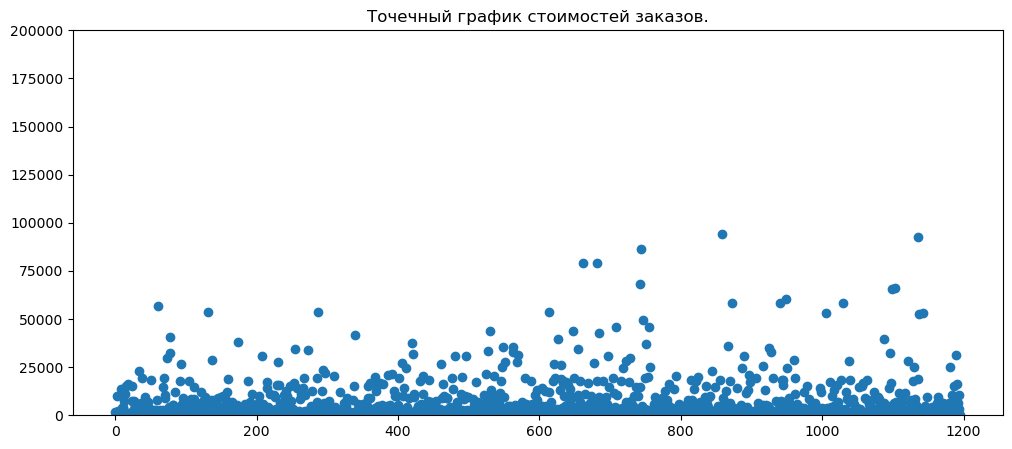

In [60]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12, 5))
plt.title(label='Точечный график стоимостей заказов.')
plt.ylim(0, 200000)
plt.scatter(x_values, orders['revenue']);

Ограничив график по оси у, можно рассмотреть рассеивание цены вблизи: большая часть заказов, как и показали перцентили, менее 50 000 рублей.

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [20]:
np.percentile(orders['revenue'], [90, 95, 99])

Не больше, чем у 5% заказов чек дороже 28 000 рублей, и только у 1% - дороже 58 233 р.


Из этого можно сделать вывод, что заказы на 200 тысяч и 1,2 миллиона действительно аномальны и могут исказить данные. 

За аномальных пользователей принимаем тех, кто совершил 4 заказа и более или совершил заказ на сумму свыше 35 000 рублей.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Нулевая гипотеза: среднее количество заказов на посетителя между группами А и В не отличаются.

Альтернативная гипотеза: среднее количество заказов на посетителя между группами А и В имеют статистически значимые отличия. 

Уровень значимости принимаем за 0.05.

In [67]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Отвергаем нулевую гипотезу - p-value меньше 0.05, группа В имеет показатели выше на 13.8%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Нулевая гипотеза: средний чек между группами не отличается.

Альтернативная гипотеза: средний чек между группами имеет статистически значимое отличие. 

Уровень значимости принимаем за 0.05.

In [63]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value в 0.72 не даёт оснований отвергнуть нулевую гипотезу - он намного выше принятого уровня значимости в 0.05. 

Анализ "сырых" данных показал, что в среднем количестве заказов между группами нет статистически значимых различий, а вот средние чеки значимо отличаются. Относительный прирост среднего группы В к среднему группы А равен 13,8%, а прирост среднего чека - 25%.

Теперь нужно очистить данные от выбросов и изучить их в очищенном виде, чтобы понять, связаны отличия с действительно большей успешностью в группе В или с выбросами. 

Приступаем к подготовке очищенных от аномалий данных. 95-й перцентиль среднего чека - 28 000 рублей, 99-й перцентиль - 58 233. 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 аказам на пользователя. 

Поэтому за аномальных пользователей принимаем тех, кто совершил 4 заказа и более или совершил заказ на сумму свыше 35 000 рублей. Так будут удалены 1% пользователей с наибольшим числом заказов и от 1% до 5% заказов с наибольшей стоимостью. 

Для этого создаём список abnormalUsers, в котором будут пользователи с аномально дорогими заказами или аномально большим их количеством. 

In [64]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 35000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

Теперь, имея список аномальных пользователей, можно очистить данные и проанализировать их. 

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Нулевая гипотеза: среднее количество заказов на посетителя между группами не отличается.

Альтернативная гипотеза: среднее количество заказов на посетителя между группами имеет статистически значимое отличие.

Уровень значимости принимаем за 0.05.

In [65]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Очищенные данные показывают статистически значимые отличия - разница составляет 15%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Нулевая гипотеза: средний чек посетителя между группами не отличается.

Альтернативная гипотеза: средний чек посетителя между группами имеет статистически значимое отличие.

Уровень значимости принимаем за 0.05.

In [66]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value составляет 0,87, это не даёт оснований отвергнуть нулевую гипотезу. 

### Промежуточный вывод

В ходе вычислений установлено, что:
- по сырым данным нет статистически значимого различия по среднему количеству заказов, после удаления аномалий также значимого различия не выявлено;
- есть статистически значимое различие в среднем чеке между группами как по сырым данным, так и после фильтрации аномалий;
- график различия среднего чека сильно колеблется, вероятно, из-за аномалий. Он не позволяет сделать значимых выводов, но позволил выявить наличие аномалий.

Вывод:

Тест можно остановить и признать успешным. График конверсии пришёл к стабильности, группа В статистически значимо лучше группы А. 

# Общий вывод

При приоритиации гипотез установлено, что согласно методу ICE, наибольший приоритет имеет гипотеза 8, предлагающая запустить акцию, дающую скидку на товар в день рождения пользователя, а согласно методу Rice, наиболее приоритетна гипотеза 7 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email рассылок.

Такая разница в результатах, вероятно, связана с тем, что метод ICE не учитывает, скольких пользователей затронет вносимое изменение. Акция, дающая скидку на товар в день рождения пользователя, затронет только часть пользователей - тех, кто указал свою дату рождения, и не затронет единовременно всех пользователей. Форма подписки на всех основных страницах затронет большую часть пользователей интернет-магазина.


Результаты А/В-теста.

В ходе вычислений установлено, что:

- по сырым данным нет статистически значимого различия по среднему количеству заказов, после удаления аномалий также значимого различия не выявлено;
- есть статистически значимое различие в среднем чеке между группами как по сырым данным, так и после фильтрации аномалий;
график различия среднего чека сильно колеблется, вероятно, из-за аномалий. Он не позволяет сделать значимых выводов, но позволил выявить наличие аномалий.

Тест можно остановить и признать успешным. График конверсии пришёл к стабильности, группа В статистически значимо лучше группы А.